In [9]:
##import reqiuired packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
%matplotlib inline
import cv2
import os



from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Input, BatchNormalization, Conv2D, MaxPooling2D
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import datetime
from PIL import Image
from keras.preprocessing.image import img_to_array, ImageDataGenerator

In [4]:
!unzip -q "/content/drive/MyDrive/intern dl/archive (3).zip"


replace samples/226md.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
global path
path = '/content/samples'

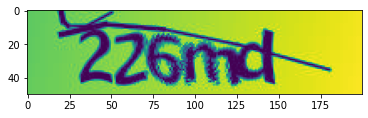

In [10]:
#3load images into graysclae
import cv2
img = cv2.imread(path+'/226md.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img)

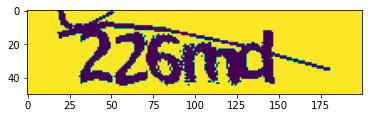

In [11]:
##Add Binary threshold to it
ret, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
plt.imshow(img)

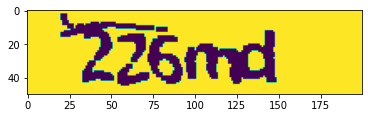

In [13]:
#Add morphology
img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((3,4), np.uint8))
plt.imshow(img)

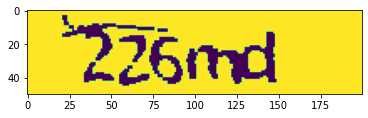

In [14]:
#Add dilate
img = cv2.dilate(img, np.ones((2,2), np.uint8), iterations = 1)
plt.imshow(img)

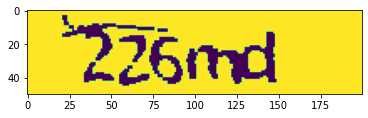

In [15]:
#Add Gaussian Blur
img = cv2.GaussianBlur(img, (1,1), 0)
plt.imshow(img)

Now we will split the each digit in the image
To do this we need to draw rectangle around each digit so that it will be easy to split each digit

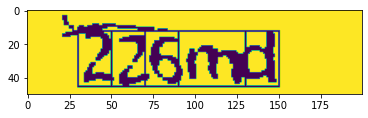

In [16]:
cv2.rectangle(img, (30, 12), (50, 45), 0, 1)
cv2.rectangle(img, (50, 12), (70, 45), 0, 1)
cv2.rectangle(img, (70, 12), (90, 45), 0, 1)
cv2.rectangle(img, (90, 12), (130, 45), 0, 1)
cv2.rectangle(img, (130, 12), (150, 45), 0, 1)
plt.imshow(img)

In [17]:
##now we folow same steps for all the imaeges
def img_trans(img) :
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    ret, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((3,4), np.uint8))
    img = cv2.dilate(img, np.ones((2,2), np.uint8), iterations = 1)
    img = cv2.GaussianBlur(img, (1,1), 0)
    return img

In [18]:
def img_arr():
    x = []
    y = []
    for image in os.listdir(path):
        if image[6:] != 'png':
            continue

        img = img_trans(path+'/'+image)
        image_list = [img[10:50, 30:50], img[10:50, 50:70], img[10:50, 70:90], img[10:50, 90:110], img[10:50, 110:130]]
        for i in range(5):
            x.append(img_to_array(image_list[i]))
            y.append(image[i])

    x = np.array(x)
    y = np.array(y)
    return x, y

In [21]:
x,y = img_arr()

y.shape

(5200,)

In [20]:
x.shape

(5200, 40, 20, 1)

In [22]:
##Scale b/w 0 and 1
x /= 255.0

In [23]:
##Count the number of occurance of each character in the dataset
for i in set(y):
    c = list(y).count(i)
    print(str(i)+" occured: "+str(c)+" times")

2 occured: 265 times
p occured: 253 times
g occured: 271 times
8 occured: 264 times
f occured: 271 times
m occured: 275 times
5 occured: 281 times
c occured: 262 times
e occured: 235 times
b occured: 240 times
n occured: 525 times
6 occured: 259 times
3 occured: 267 times
y occured: 232 times
d occured: 259 times
4 occured: 284 times
w occured: 235 times
7 occured: 258 times
x occured: 264 times


In [24]:
##One Hot Encoding for each character
y_combine = LabelEncoder().fit_transform(y)
y_one_hot = OneHotEncoder(sparse = False).fit_transform(y_combine.reshape(len(y_combine),1))

In [25]:
info = {y_combine[i] : y[i] for i in range(len(y))}
print(info)

{16: 'w', 18: 'y', 8: 'c', 0: '2', 3: '5', 10: 'e', 14: 'n', 2: '4', 1: '3', 9: 'd', 4: '6', 17: 'x', 11: 'f', 7: 'b', 6: '8', 13: 'm', 15: 'p', 12: 'g', 5: '7'}


In [26]:
x.shape


(5200, 40, 20, 1)

In [27]:
print(y_one_hot.shape)

(5200, 19)


In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y_one_hot, test_size = 0.2, random_state = 42)

In [31]:


x_train.shape
y_train.shape

(4160, 19)

In [32]:
##Data Augmentation and Oversampling
x_train = np.reshape(x_train, (4160, 40*20*1))
from imblearn.over_sampling import SMOTE
x_train, y_train = SMOTE(sampling_strategy = 'auto', random_state = 42).fit_resample(x_train, y_train)
print(x_train.shape)
print(y_train.shape)

(7866, 800)
(7866, 19)


In [34]:
x_train = np.reshape(x_train, (7866, 40, 20, 1))

In [35]:
traingen = ImageDataGenerator(rotation_range = 5, width_shift_range = [-2,2])
traingen.fit(x_train)
train_set = traingen.flow(x_train, y_train)
train_x, train_y = train_set.next()

In [36]:
##Building the model architecture
INPUT_SHAPE = (40, 20, 1)
NUM_CLASSES = 19
model = keras.Sequential()
model.add(Conv2D(filters=128,
                kernel_size=3,
                activation='relu',
                padding = 'same',
                input_shape = INPUT_SHAPE
                )
         )
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64,
                activation='relu',
                kernel_size=3,
                padding='same'
                )
         )
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64,
                activation='relu',
                kernel_size=3,
                padding='same'
                )
         )
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())

model.add(Dense(units = 32,activation="tanh"))
model.add(Dense(units = 20,activation="tanh"))

model.add(Dense(NUM_CLASSES, activation="softmax"))

model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.000529),
             loss="categorical_crossentropy",
             metrics="accuracy"
             )

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 20, 128)       1280      
                                                                 
 batch_normalization (BatchN  (None, 40, 20, 128)      512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 40, 20, 128)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 10, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 10, 64)        73792     
                                                                 
 batch_normalization_1 (Batc  (None, 20, 10, 64)       2

In [ ]:
history = model.fit(traingen.flow(x_train, y_train, batch_size = 32), validation_data = (x_test, y_test), epochs = 150, steps_per_epoch = len(x_train)/32)

Epoch 1/150
245/245 [==============================] - 54s 216ms/step - loss: 2.0319 - accuracy: 0.4926 - val_loss: 2.4134 - val_accuracy: 0.2558
Epoch 2/150
245/245 [==============================] - 63s 258ms/step - loss: 1.1336 - accuracy: 0.7836 - val_loss: 1.3126 - val_accuracy: 0.6913
Epoch 3/150
245/245 [==============================] - 55s 222ms/step - loss: 0.7839 - accuracy: 0.8360 - val_loss: 0.8419 - val_accuracy: 0.8125
Epoch 4/150
245/245 [==============================] - 55s 225ms/step - loss: 0.6192 - accuracy: 0.8609 - val_loss: 0.7192 - val_accuracy: 0.8337
Epoch 5/150
245/245 [==============================] - 54s 220ms/step - loss: 0.5236 - accuracy: 0.8716 - val_loss: 0.6275 - val_accuracy: 0.8365
Epoch 6/150
245/245 [==============================] - 54s 218ms/step - loss: 0.4633 - accuracy: 0.8830 - val_loss: 0.5656 - val_accuracy: 0.8490
Epoch 7/150
245/245 [==============================] - 54s 219ms/step - loss: 0.4177 - accuracy: 0.8923 - val_loss: 0.6695 -